In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torchvision import transforms
from torchvision.models import resnet50

# 1. Класс НОРМАЛИЗАТОРА

In [20]:
class SimpleCNNModel(nn.Module) :
    def __init__(self):
        super().__init__()
        self.model = resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, 68*2)

    def forward(self, x) :
        output = self.model(x)
        return output

In [25]:
class Normalizer():
    def __init__(self, model, img):
        self.model = model
        self.transform = A.Compose([
            A.Resize(220, 220),
            ToTensorV2()
        ])

        self.img = self.transform(image=img)['image']


    def coord_landmarks(self):
        predict = self.model(torch.tensor(np.expand_dims(self.img, axis=0)).float())

        num_landmarks = [i for i in range(16, -1, -1)] + [i for i in range(17, 20)] + [i for i in range(24, 27)] + [16]

        x_pred = predict.detach().numpy()[0, ::2][num_landmarks]
        y_pred = predict.detach().numpy()[0, 1::2][num_landmarks]

        x_pred = x_pred.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)

        coords = np.concatenate((x_pred, y_pred), axis=1)

        return coords


    def show_landmarks(self):
        coords = self.coord_landmarks()
        x = coords[:, 0]
        y = coords[:, 1]
        size_points = 10

        img = self.img.numpy()[0]

        plt.scatter(x, y, s=size_points)
        plt.imshow(img, cmap='gray')


    def normalizer(self):
        coords = self.coord_landmarks().astype(int)
        self.img = self.img.numpy()[0]

        mask = np.zeros((self.img.shape[0], self.img.shape[1]))
        mask = cv2.fillConvexPoly(mask, coords, (255, 255, 255))
        mask = mask.astype(bool)

        out = np.zeros_like(self.img)
        out[mask] = self.img[mask]

        plt.imshow(out, cmap='gray')
        plt.axis('off')

        return out


# 2. Проверка нормализатора

In [26]:
model = torch.load('/content/drive/MyDrive/model')

In [27]:
def img_processing(img_path):
    img = cv2.imread(img_path)
    return img


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
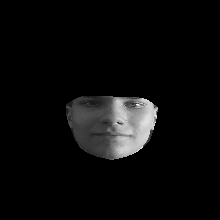

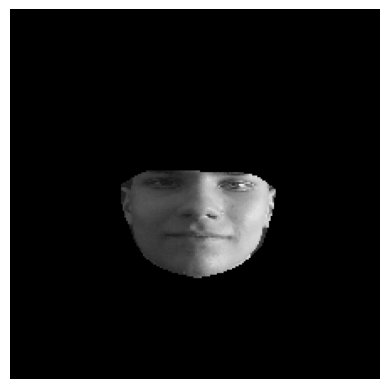

In [28]:
img_path = '/content/drive/MyDrive/IMG_20230913_153416.jpg'
img = img_processing(img_path)

norm = Normalizer(model, img)
norm.normalizer()